# Variational Quantum Classifier - toy example

## Contents

1. [Installing dependencies](#intro)    
2. [Classification on a Quantum Computer](#vqc)    
    2.1 [Loading Data onto the Quantum Computer](#feature-maps)    
    2.2 [Building the Circuit that Classifies](#var-forms)      
    2.3 [Measurement and Assigning a Binary Label](#validate)      
    2.4 [Classical optimization loop](#classical-optimization)    
3. [Classifying a toy dataset](#full)


## 1. Installing Dependencies <a id="intro"></a>

In [ ]:
##### NOTE: Only run this locally in case you don't have the dependencies mentioned below ######

# installing a few dependencies
!pip install --upgrade seaborn==0.10.1
!pip install --upgrade scikit-learn==0.23.1
!pip install --upgrade matplotlib==3.2.0
!pip install --upgrade pandas==1.0.4
!pip install --upgrade qiskit==0.19.6 

# the output will be cleared after installation
from IPython.display import clear_output
clear_output()

## 2. Classification on a Quantum Computer <a id="vqc"></a>

There are multiple methods for classifying a dataset using a quantum computer, however, today we will concentrate on a method called the **Variational Quantum Classifier (VQC)** as proposed in the paper [Havlicek et.al](https://arxiv.org/abs/1804.11326) [1]. The paper also proposes another method called the the **Kernel Estimation Method** which may be interesting for those curious. 

Similar to classical machine learning the VQC algorithm has a **training stage** (where datapoints with labels are provided and learning takes place) and a **testing stage** (where new datapoints without labels are provided which are then classified). Each of these stages in VQC are a four step process: 

* **Loading Data onto the Quantum Computer** (Apply Feature Map)
* **Building the Circuit that Classifies** (Variational Circuit) 
* **Measurement and Assigning a Binary Label**
* **Classical Optimization Loop**

![vqc](./images/vqc.png)

Through the course of this notebook we will look at each of these steps and gain an understanding on how the VQC algorithm works using the inbuilt `VQC` algorithm in Qiskit Aqua. Further, we will look at how we can use the `VQC` class in Qiskit Aqua to classify `0`'s and `1`'s along with customization of the algorithm to your needs. 

### 2.1 Loading Data onto the Quantum Computer <a id="feature-maps"></a>

Check out the qiskit-community tutorial on custom feature maps [here](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/machine_learning/custom_feature_map.ipynb) from which this section has been adapted. It has a few extra details on how to configure a custom `data map function` $\phi_S$ which might be interesting when working with the inbuilt **quantum feature maps** (or Data Encoding Circuits) in Qiskit. 

The idea of quantum feature maps comes from the theory of kernels in classical machine learning where a dataset is mapped non-linearly onto a higher dimensional space where a hyperplane can be found that classifies it. 

As the name suggests, a **quantum feature map $\phi(\vec{x})$** is a map from the classical feature vector $\vec{x}$ to the quantum state $|\Phi(\vec{x})\rangle\langle\Phi(\vec{x})|$, a vector in Hilbert space. This is faciliated by applying the unitary operation $\mathcal{U}_{\Phi(\vec{x})}$ on the initial state $|0\rangle^{n}$ where _n_ is the number of qubits being used for encoding. By doing this process we have now blown up the dimension of our feature space and the task of our classifier is to find a separating hyperlane in this new space.

Constructing feature maps based on quantum circuits that are hard to simulate classically is an important step towards obtaining a quantum advantage over classical approaches. The authors of [[1]](https://arxiv.org/abs/1804.11326) proposed a family of feature maps that is conjectured (recently proved by another group) to be hard to simulate classically and that can be implemented as short-depth circuits on near-term quantum devices. The quantum feature map of depth $d$ is implemented by the unitary operator 

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_k\right) $$

which contains layers of Hadamard gates interleaved with entangling blocks encoding the classical data as shown in circuit diagram below for $d=2$.

<img src="./images/uphi.PNG" width="400" />

The number of qubits $n$ in the quantum circuit is equal to the dimensionality of the classical data $\mathbf{x}$ in these feature encodings, which are encoded through the coefficients $\phi_S(\mathbf{x})$, where $S \subseteq[n] = \{1, \ldots, n \}$. We call the $r$-th order expansion the feature map of this circuit family when $|S|\leq r$. In Terra, the default is the second order expansion $|S|\leq 2$ used in [[1]](https://arxiv.org/abs/1804.11326), which gives $n$ singeltons $S=\{i\}$ and, depending on the connectivity graph of the quantum device, up to $\frac{n(n-1)}{2}$ couples to encode entangling interactions. The greater the upper bound $r$, the more interactions will be taken into account.

Only contributions from $Z$ and $ZZ$ gates in the entangling blocks are considered in [[1]](https://arxiv.org/abs/1804.11326). In general, the blocks can be expressed in terms of the Pauli gates $P_k \in \{\mathbb{1}_k, X_k, Y_k, Z_k \}$.

In the Terra circuit library, the circuit depth $d$, coefficients $\phi_S$, entanglement, and gates $P_k$ are mutable for Variational Quantum Classifier. As discussed in [[1]](https://arxiv.org/abs/1804.11326), the depth $d=1$ circuit can be efficiently simulated classically by uniform sampling, while the $d=2$ variant is conjectured to be hard to simulate classically.

### Using Feature Maps from the Terra Circuit Library

We will now learn how to configure inbuilt quantum feature maps in Qiskit Terra by modifing the `circuit depth` $d$, `entanglement`, and gates $P_k$. Documentation on the quantum feature maps in Terra can be found in the [Circuit Library](https://qiskit.org/documentation/apidoc/circuit_library.html) under the "Data Encoding Circuits" section. 

We'll see how to build quantum feature maps inbuilt in Qiskit and a method to build your own custom feature map. A feature map is essentially a variational circuit and Qiskit Terra's circuit library has numerous variational circuits one could use for building their quantum feature map. However, the circuits specific to the data preparation step used in the paper [[1]](https://arxiv.org/abs/1804.11326) are : 

* ZFeatureMap
* ZZFeatureMap
* PauliFeatureMap

These are also the feature maps that are available in Qiskit. Lets start by importing what is required.

In [4]:
from qiskit import *
import numpy as np

import time
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC

### ZFeatureMap

A first order diagonal expansion is implemented using the `ZFeatureMap` feature map where $|S|=1$. The resulting circuit contains no interactions between features of the encoded data, and therefore no entanglement. The feature map can take the following inputs:

- `feature_dimension`: dimensionality of the classical data (equal to the number of required qubits)
- `reps`: number of times $d$ the feature map circuit is repeated
- `data_map_func`: function $\phi_S(\mathbf{x})$ encoding the classical data.

The default setting `data_map_func = self_product()` for the `ZFeatureMap` has $S = \{i\}$ and is given by 

$$\phi_S:x\mapsto x_i.$$

In [5]:
feature_dim = 3     # equal to the dimension of the data

Z_feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=4)
Z_feature_map.draw()

┌───┐┌──────────────┐┌───┐┌──────────────┐┌───┐┌──────────────┐┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├┤ H ├»
     ├───┤├──────────────┤├───┤├──────────────┤├───┤├──────────────┤├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├┤ H ├»
     ├───┤├──────────────┤├───┤├──────────────┤├───┤├──────────────┤├───┤»
q_2: ┤ H ├┤ U1(2.0*x[2]) ├┤ H ├┤ U1(2.0*x[2]) ├┤ H ├┤ U1(2.0*x[2]) ├┤ H ├»
     └───┘└──────────────┘└───┘└──────────────┘└───┘└──────────────┘└───┘»
«     ┌──────────────┐
«q_0: ┤ U1(2.0*x[0]) ├
«     ├──────────────┤
«q_1: ┤ U1(2.0*x[1]) ├
«     ├──────────────┤
«q_2: ┤ U1(2.0*x[2]) ├
«     └──────────────┘

A good point to note at this point is that the `U1Gate` is an anti-clockwise rotation around the Z axis which changes the relative phase of a qubit, i.e, the $R_Z(\phi)$ gate. And the reason why we see a factor of `2.0` inside all the gates, i.e, such as `U1(2.0*x[0])` is because $U_{\Phi(\mathbf{\theta})}=\exp\left(i\phi(\mathbf{\theta})Z_k\right)$ and we know that $R_P(\theta) = e^{(-i\frac{\theta}{2}P)}$ where $P$ is a Pauli X, Y or Z matrix.

In [6]:
print("parameters of the Z Feature Map are: {}".format(Z_feature_map.parameters))

parameters of the Z Feature Map are: {Parameter(x[2]), Parameter(x[0]), Parameter(x[1])}


On playing around with the `feature_dim` attribute on `ZFeatureMap` we realize that for encoding data of dimension _d_ we require _d_ qubits. And this brings us to the reason why we applied dimension reduction techniques in the classical pre-processing step. Initially the data was of dimension 784 implying that we would require 784 qubits to encode it! Post the dimensionality reduction, we only require 2 qubits. We could however increase this dimension and test our accuracies - A good project to tinker on. 

The parameters $x[0], x[1]$ and $x[2]$ will be binded with the values of our feature vector $\vec{x}$ during the implementation of our algorithm and thus becomes an immutable circuit. It is important to note that though we utilize variational circuits to build the Feature Map there is no learning of parameters taking place but the substitution of our data values.  

### ZZFeatureMap

The `ZZFeatureMap` feature map allows $|S|\leq 2$, so interactions in the data will be encoded in the feature map according to the connectivity graph and the classical data map. `ZZFeatureMap` with default parameters is equivalent to the feature map described in [1] and can take the additional inputs:

- `entanglement`: generates connectivity `'full'` or `'linear'` or defining your own entanglement structure (default value `'full'` indicates a complete connectivity graph of $\frac{n(n-1)}{2}$ interactions)

The default setting of the data map function in `ZZFeatureMap` is given by

$$\phi_S:x\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$.

In [7]:
feature_dim = 2

ZZ_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, insert_barriers=True)
ZZ_feature_map.draw()

┌───┐┌──────────────┐     »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■──»
     ├───┤├──────────────┤┌─┴─┐»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├»
     └───┘└──────────────┘└───┘»
«                                                                         ┌───┐»
«q_0: ─────────────────────────────────────────────────────────────────■──┤ H ├»
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐├───┤»
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├┤ H ├»
«     └─────────────────────────────────────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐     »
«q_0: ┤ U1(2.0*x[0]) ├──■──»
«     ├──────────────┤┌─┴─┐»
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├»
«     └──────────────┘└───┘»
«                                                                         
«q_0: ─────────────────────────────────────────────────────────────────■──
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├
«     └─────────────────────────────────────────────────────────────┘└───┘

In [8]:
print("parameters of the Z Feature Map are: {}".format(ZZ_feature_map.parameters))

parameters of the Z Feature Map are: {Parameter(x[0]), Parameter(x[1])}


### PauliFeatureMap

For some applications, we may want to consider a more general form of the feature map. One way to generalize is to use `PauliFeatureMap` and specify a set of Pauli gates instead of using the default $Z$ gates. This feature map has the same parameters as `ZFeatureMap` and `ZZFeatureMap` such as `reps` and `data_map_func` along with an additional `paulis` parameter to change the gate set. This parameter is a list of strings, each representing the desired Pauli gate(s). The default value is `['Z', 'ZZ']`, which is equivalent to `ZZFeatureMap`.


Each string in `paulis` is implemented one at a time for each layer in the depth $d$ feature map circuit. A single character, for example `'Z'`, adds one layer of the corresponding single-qubit gates, while terms such as `'ZZ'` or `'XY'` add a layer of corresponding two-qubit entangling gates for each qubit pair available based on `entanglement`.

For example, the choice `paulis = ['Z', 'Y', 'ZZ']` generates a quantum feature map of the form 

$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

The depth $d=1$ version of this quantum circuit is shown in the figure below for $n=2$ qubits.


<img src="./images/depth1.PNG" width="400"/>


The circuit begins with a layer of Hadamard gates $H^{\otimes n}$ followed by a layer of single-qubit $A = e^{i\phi_{\{j\}}(\mathbf{x})Z_j}$ gates and a layer of $B = e^{i\phi_{\{j\}}(\mathbf{x}) \, Y_j}$ gates. The $A$ and $B$ gates are parametrized by the same set of angles $\phi_{\{j\}}(\mathbf{x})$ but around different axes. The diagonal entangling gate $e^{i \phi_{\{0,1\}}(\mathbf{x}) \, Z_0 \otimes Z_1}$ is parametrized by an angle $\phi_{\{0,1\}}(\mathbf{x})$ and can be implemented using two controlled-NOT gates and one $A'=e^{i\phi_{\{0,1\}}(x)\, Z_1}$ gate as shown in the figure.

As a comparison, `paulis = ['Z', 'ZZ']` creates the same circuit as above but without the $B$ gates, while `paulis = ['Z', 'YY']` creates a circuit with a layer of $A$ gates followed by a layer of entangling gates $e^{i \phi_{\{0,1\}}(\mathbf{x}) \, Y_0 \otimes Y_1}$.

Below, we test the `PauliFeatureMap` with `paulis=['Z', 'Y', 'ZZ']`.

In [9]:
feature_dim = 2

pauli_feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, paulis = ['Z','X','ZY'])
pauli_feature_map.draw()

┌───┐┌──────────────┐┌───┐┌──────────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ RX(pi/2) ├──■──»
     ├───┤├──────────────┤├───┤├──────────────┤├───┤└──────────┘┌─┴─┐»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├┤ H ├────────────┤ X ├»
     └───┘└──────────────┘└───┘└──────────────┘└───┘            └───┘»
«                                                                         »
«q_0: ─────────────────────────────────────────────────────────────────■──»
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐»
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├»
«     └─────────────────────────────────────────────────────────────┘└───┘»
«     ┌───────────┐
«q_0: ┤ RX(-pi/2) ├
«     └───────────┘
«q_1: ─────────────
«

These are the feature maps present in Qiskit and are the ones mentioned in the paper [[1]](https://arxiv.org/abs/1804.11326) as well. It is important to note that the feature maps used in the paper were designed with the aim for them to be hard to simulate on a classical computer and are not known to have a [kernel function](https://en.wikipedia.org/wiki/Kernel_method) for the dot product which can be efficiently computed classically. 

The dataset used in the paper was tailor-made to get a high classification accuracy with the quantum feature maps used. However, these feature maps may not perform well with other datasets. For a particular dataset, finding a quantum feature map that can spread the datapoints in Hilbert space in such a way that a hyperplane can be drawn to classify them is important to gain higher accuracies for our model. 

Further, it is important for the corresponding quantum feature map circuit to be shallow (i.e, have a small circuit depth) as decoherence will come into play and decrease our accuracies. Similarily having more 2-qubit gates will increase the error in the circuit thus leading to further decrease in accuracy. To understand more about errors in real quantum computers you can look at [this section](https://qiskit.org/textbook/ch-quantum-hardware/index-circuits.html) of the Qiskit textbook. This will not be required for the challenge going forward as we will only use local simulators. Creating such short depth feature maps for real-world datasets is an open problem and an active field of research in Quantum Machine Learning.

As being able to construct tailor-made feature maps is important for increasing the accuracy we will look at a method to create your very own variational circuits in the following section. This can be used to create custom feature maps as well. 

### 2.2 Building the Circuit that Classifies <a id="var-forms"></a>

In this step we append a short depth [Variational Circuit](https://qiskit.org/documentation/tutorials/circuits_advanced/1_advanced_circuits.html) to the previously constructed feature map. The parameters of this variational circuit are then trained in the [classical optimization loop](#classical-optimization) until it classifies the datapoints correctly. This is the learning stage of the algorithm and accuracy of the model can vary based on the variational circuit one chooses. It is essential to choose a variational circuit of shorter depth (making it especially viable for implementations on real hardware), lesser number of parameters to train (faster training process) while making sure its [_Expressability and Entangling capacity_](https://arxiv.org/pdf/1905.10876.pdf) are enough to classify our dataset to the degree we want. Building variational circuits with such conflicting properties, similar to the study on quantum feature maps, is an active field of research.

Coming to the implementation details, In Terra one can build variational circuits using multiple classes such as the `NLocal`, `RealAmplitudes` or the `FunctionalPauliRotations` class from the Terra circuit library. More variational forms can be found in the [documentation](https://qiskit.org/documentation/apidoc/circuit_library.html), [codebase](https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library).

**Constructing using [`Real Amplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html):**

Let us create a variational circuit using the inbuilt `Real Amplitudes` method. Do check out the [documentation page](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) to understand more about its working.

In [10]:
from qiskit.circuit.library import RealAmplitudes

num_qubits = 2

classifier_circ = RealAmplitudes(num_qubits, entanglement='full', reps=3)
classifier_circ.draw()

┌──────────┐     ┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ RY(θ[0]) ├──■──┤ RY(θ[2]) ├──■──┤ RY(θ[4]) ├──■──┤ RY(θ[6]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ RY(θ[1]) ├┤ X ├┤ RY(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ X ├┤ RY(θ[7]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘└───┘└──────────┘

**Constructing a Custom Variational Circuit/Feature Map:** 

Up until this point we have learnt how to create feature maps and variational circuits using inbuilt methods in Qiskit. Now, let's create a custom variational circuit which can be used either in the place of a `FeatureMap` or as a `VariationalCircuit`. 

Creating a custom variational circuit is simple. While creating a `QuantumCircuit`, in the place where you would normally insert an angle you now have to insert a [`Parameter`](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html) object and this transforms our circuit into a variational circuit. For the sake of convenience we could use [`ParameterVector`](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html) to create a list of Pararmeters. Here's an example:

In [11]:
from qiskit.circuit import QuantumCircuit, ParameterVector

num_qubits = 3            
reps = 1              # number of times you'd want to repeat the circuit

x = ParameterVector('x', length=num_qubits)  # creating a list of Parameters
custom_circ = QuantumCircuit(num_qubits)

# defining our parametric form
for _ in range(reps):
    for i in range(num_qubits):
        custom_circ.rx(x[i], i)
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            custom_circ.cx(i, j)
            custom_circ.u1(x[i] * x[j], j)
            custom_circ.cx(i, j)
            
custom_circ.draw()

┌──────────┐                                                           »
q_0: ┤ RX(x[0]) ├──■─────────────────────■────■─────────────────────■───────»
     ├──────────┤┌─┴─┐┌───────────────┐┌─┴─┐  │                     │       »
q_1: ┤ RX(x[1]) ├┤ X ├┤ U1(x[0]*x[1]) ├┤ X ├──┼─────────────────────┼────■──»
     ├──────────┤└───┘└───────────────┘└───┘┌─┴─┐┌───────────────┐┌─┴─┐┌─┴─┐»
q_2: ┤ RX(x[2]) ├───────────────────────────┤ X ├┤ U1(x[0]*x[2]) ├┤ X ├┤ X ├»
     └──────────┘                           └───┘└───────────────┘└───┘└───┘»
«                           
«q_0: ──────────────────────
«                           
«q_1: ───────────────────■──
«     ┌───────────────┐┌─┴─┐
«q_2: ┤ U1(x[1]*x[2]) ├┤ X ├
«     └───────────────┘└───┘

During the challenge phase, creating a custom feature map will become crucial in improving the accuracy of your model as it gives the freedom to create an effective feature map and variational circuit tailor made for your dataset. However, as we discussed earlier, the idea of "how" to create an effective feature map and variational circuit for a particular dataset are active fields of research and there is no concrete answer to it yet.

### 2.3 Measurement and Assigning a Binary Label <a id="validate"></a> 

After creating and measuring the circuit we are left with an _n_ bit classical string from which we must derive a binary output which will be our classification result. This is done with the help of a boolean function $f: \{0, 1\}^{n} -> \{0, 1\}$. The way this boolean function is written out may not be as significant as the concepts earlier as modifying the boolean function will change the values of the parameters learned to accommodate for the change. Common examples of boolean functions are:

* **Parity function** : modulus 2 sum of all the digits of the _n_ bit classical string. 
* **Choosing the "k"th digit** : Choose the digit number "k" in the _n_ bit classical string as the output, etc.

This functionality is already inbuilt in the `VQC` method in Qiskit Aqua and you won't have to make any changes to it.

### 2.4 Classical optimization loop <a id="classical-optimization"></a> 

Once we get our predictions a classical optimization routine changes the values of our variational circuit and repeats the whole process again. This is the classical loop that trains our parameters until the cost function value decreases. The details of the working have been ommitted as they are immutable and are not relevant going forward. However, you can look at the [code](https://github.com/Qiskit/qiskit-aqua/blob/master/qiskit/aqua/algorithms/classifiers/vqc.py) and the [optimization step](https://github.com/Qiskit/qiskit-aqua/blob/f5efe642f6374da45b96c5a73a9a01121f95081e/qiskit/aqua/algorithms/classifiers/vqc.py#L661) to understand exactly how this step takes place. 

Though there's isn't an available option to change the cost function during the optimization of VQC, Aqua provides you with a plethora of Optimization methods you could use during the training stage of the process. Here are a few for your reference:

**Commonly used optimization methods in Aqua:**

* COBYLA - Constrained Optimization By Linear Approximation optimizer.
* SPSA - Simultaneous Perturbation Stochastic Approximation (SPSA) optimizer.
* SLSQP - Sequential Least Squares Programming optimizer, etc.

The complete list can be found in the [documentation](https://qiskit.org/documentation/apidoc/qiskit.aqua.components.optimizers.html). 

## 3. Classifying a toy dataset <a id="full"></a>

In [12]:
from qiskit.ml.datasets import ad_hoc_data
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

Lets apply what we've learned using the **VQC method in Aqua** to classify a toy dataset.

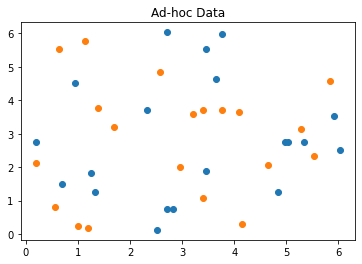

{'A': 0, 'B': 1}


In [13]:
feature_dim = 2 # dimension of each data point
training_dataset_size = 20
testing_dataset_size = 10
random_seed = 10598
shots = 1024

sample_Total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=training_dataset_size, 
    test_size=testing_dataset_size, 
    n=feature_dim, gap=0.3, plot_data=True
)
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
print(class_to_label)

**Instantiate the Feature map to use:**

In [18]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
feature_map.draw()


┌───┐┌──────────────┐     »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■──»
     ├───┤├──────────────┤┌─┴─┐»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├»
     └───┘└──────────────┘└───┘»
«                                                                         ┌───┐»
«q_0: ─────────────────────────────────────────────────────────────────■──┤ H ├»
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐├───┤»
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├┤ H ├»
«     └─────────────────────────────────────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐     »
«q_0: ┤ U1(2.0*x[0]) ├──■──»
«     ├──────────────┤┌─┴─┐»
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├»
«     └──────────────┘└───┘»
«                                                                         
«q_0: ─────────────────────────────────────────────────────────────────■──
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├
«     └─────────────────────────────────────────────────────────────┘└───┘

**Instantiate the Classical Optimizer to use:**

In [29]:
from qiskit.aqua.components.optimizers import COBYLA, SPSA

# init cobyla
cobyla = COBYLA(maxiter=500, tol=0.001)

#init spsa
spsa = SPSA(max_trials=100, c0=4.0, skip_calibration=True)
spsa.set_options(save_steps=1)

**Instantiate the variational Circuit to use:**

In [20]:
from qiskit.circuit.library import EfficientSU2, RealAmplitudes

var = EfficientSU2(feature_dim, reps=2)
var.draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├──■──┤ RY(θ[8]) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├┤ X ├┤ RY(θ[9]) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
«     ┌───────────┐
«q_0: ┤ RZ(θ[10]) ├
«     ├───────────┤
«q_1: ┤ RZ(θ[11]) ├
«     └───────────┘

Constructing a callback function to get the parameter values after each iteration. This step is optional but highly recommended to see if the algorithm is working and is optimizing your parameters as you'd expect it to. 

In [21]:
def call_back_vqc(eval_count, var_params, eval_val, index):
    print("eval_count: {}".format(eval_count))
    print("var_params: {}".format(var_params))
    print("eval_val: {}".format(eval_val))
    print("index: {}".format(index))

**Bringing everything together**

In [30]:
# initilizing our backend
backend = BasicAer.get_backend('qasm_simulator')
backend_options = {"method": "statevector"}

# creating a quantum instance
quantum_instance = QuantumInstance(backend, shots=1024, 
                                   seed_simulator=random_seed, 
                                   seed_transpiler=random_seed, 
                                   backend_options=backend_options)

# initilizing our VQC object
vqc = VQC(optimizer=spsa, 
          feature_map=feature_map, 
          var_form=var, 
          callback=call_back_vqc, 
          training_dataset=training_input, 
          test_dataset=test_input)

In [31]:
start = time.process_time()

result = vqc.run(quantum_instance)

print("time taken: ")
print(time.process_time() - start)


print("testing success ratio: {}".format(result['testing_accuracy']))

eval_count: 0
var_params: [ 1.19023943  0.58352835 -0.90405595 -0.97971778  0.4586991  -1.29655307
 -0.77458842 -1.96582643  0.42645378 -1.94381246  0.81775728 -0.45498658]
eval_val: 0.5407468035921866
index: 0
eval_count: 1
var_params: [ 1.39023943  0.78352835 -0.70405595 -0.77971778  0.6586991  -1.49655307
 -0.57458842 -2.16582643  0.62645378 -2.14381246  1.01775728 -0.25498658]
eval_val: 0.6587327991404682
index: 1
eval_count: 2
var_params: [-1.16271913 -1.58295292 -3.07053722 -3.33267634 -1.70778217  1.05640549
 -3.12754698  0.20065483 -1.92650478  0.4091461  -1.53520128 -2.80794514]
eval_val: 0.9762407571428939
index: 2
eval_count: 3
var_params: [-0.97624184 -1.76943021 -3.25701451 -3.14619904 -1.89425946  0.86992819
 -2.94106969  0.38713213 -1.74002748  0.2226688  -1.34872398 -2.62146784]
eval_val: 0.9605789964393843
index: 3
eval_count: 4
var_params: [-0.75864575 -1.80803137 -3.29561567 -3.10759789 -1.93286062  0.6523321
 -2.90246853  0.42573329 -1.70142633  0.00507271 -1.310122

eval_count: 39
var_params: [-1.77787604 -5.51148262 -1.2026951   0.71063946  0.67909361  4.03457647
 -2.93628156  1.13231332  1.00833983 -0.2651981  -3.48469837 -6.41408757]
eval_val: 0.23928759559630222
index: 39
eval_count: 40
var_params: [-1.78967234 -5.52327892 -1.21449139  0.69884316  0.69088991  3.87572313
 -2.94807786  1.29116667  0.84948649 -0.10634475 -3.49649467 -6.40229128]
eval_val: 0.23715349185809348
index: 40
eval_count: 41
var_params: [-1.93672939 -5.67033597 -1.36154844  0.55178611  0.83794696  4.02278018
 -3.09513491  1.14410962  0.99654353 -0.2534018  -3.64355172 -6.25523423]
eval_val: 0.23174846138835212
index: 41
eval_count: 42
var_params: [-1.9599025  -5.54714136 -1.38472156  0.67498072  0.86112007  4.04595329
 -3.11830802  1.26730423  1.01971665 -0.27657491 -3.66672483 -6.23206112]
eval_val: 0.22416829486547485
index: 42
eval_count: 43
var_params: [-1.81353478 -5.69350908 -1.23835384  0.528613    0.71475235  3.89958557
 -2.9719403   1.12093651  0.87334893 -0.1302

eval_count: 78
var_params: [-1.73236527 -5.63025115 -1.4096683   0.56417539  0.93158749  3.94511174
 -3.16523265  1.34594174  0.81082518 -0.54211378 -3.63533505 -6.2371086 ]
eval_val: 0.21809857860091256
index: 78
eval_count: 79
var_params: [-1.87015661 -5.49245981 -1.27187695  0.70196673  0.79379615  4.08290309
 -3.02744131  1.20815039  0.94861652 -0.40432244 -3.49754371 -6.09931726]
eval_val: 0.22770911457578605
index: 79
eval_count: 80
var_params: [-1.70225759 -5.66035882 -1.43977597  0.67151584  0.96169516  4.0524522
 -3.0578922   1.23860128  0.78071751 -0.43477333 -3.5279946  -6.26721627]
eval_val: 0.22250944790397612
index: 80
eval_count: 81
var_params: [-1.83970572 -5.52291069 -1.30232784  0.53406771  0.82424704  3.91500407
 -3.19534033  1.37604941  0.91816563 -0.57222145 -3.66544272 -6.12976815]
eval_val: 0.21754646735374275
index: 81
eval_count: 82
var_params: [-1.85498295 -5.64474747 -1.28705061  0.65590449  0.80896981  3.89972684
 -3.07350355  1.39132663  0.93344286 -0.45038

eval_count: 117
var_params: [-1.8812745  -5.66496714 -1.47894217  0.48455997  0.85329873  3.92404586
 -3.10640959  1.38300045  0.85476799 -0.69442973 -3.67320657 -6.20085207]
eval_val: 0.22071164491626352
index: 117
eval_count: 118
var_params: [-1.89008649 -5.54151664 -1.35549167  0.47574798  0.84448674  3.91523387
 -3.2298601   1.39181244  0.73131749 -0.70324172 -3.54975607 -6.07740156]
eval_val: 0.21237133517824702
index: 118
eval_count: 119
var_params: [-1.75782399 -5.67377913 -1.48775417  0.60801047  0.97674923  4.04749637
 -3.0975976   1.25954994  0.86357998 -0.57097922 -3.68201856 -6.20966406]
eval_val: 0.2165490118042126
index: 119
eval_count: 120
var_params: [-1.76867694 -5.53088431 -1.47690121  0.59715752  0.83385441  4.03664342
 -3.10845055  1.27040289  0.85272703 -0.58183218 -3.67116561 -6.06676923]
eval_val: 0.21818325765877855
index: 120
eval_count: 121
var_params: [-1.90071882 -5.66292618 -1.34485934  0.46511565  0.96589628  3.90460154
 -3.24049243  1.40244477  0.72068516

eval_count: 155
var_params: [-1.93935795 -5.64941345 -1.51244515  0.61131789  0.86012259  3.90373589
 -3.21663499  1.23760377  0.86874038 -0.60788951 -3.65082071 -6.17681584]
eval_val: 0.21632166463817448
index: 155
eval_count: 156
var_params: [-1.94162549 -5.65168099 -1.51471269  0.61358543  0.85785505  3.90146836
 -3.09026441  1.23533623  0.87100792 -0.60562197 -3.52445014 -6.17908338]
eval_val: 0.21384265475971395
index: 156
eval_count: 157
var_params: [-1.81298738 -5.52304287 -1.38607458  0.48494732  0.98649316  4.03010647
 -3.21890252  1.36397434  0.74236981 -0.73426008 -3.65308825 -6.05044526]
eval_val: 0.2137309871783199
index: 157
eval_count: 158
var_params: [-1.81281886 -5.52287436 -1.51438085  0.61325359  0.85818689  3.9018002
 -3.09059625  1.23566807  0.87067608 -0.60595381 -3.65325676 -6.17875154]
eval_val: 0.21602637349146964
index: 158
eval_count: 159
var_params: [-1.94129365 -5.65134915 -1.38590607  0.4847788   0.98666168  4.03027498
 -3.21907104  1.36414286  0.74220129 

eval_count: 194
var_params: [-1.94709708 -5.53197612 -1.4821639   0.45655358  1.00222729  4.03293419
 -3.23849695  1.23838434  0.86046083 -0.6607719  -3.53376435 -6.04096384]
eval_val: 0.21303283856317137
index: 194
eval_count: 195
var_params: [-1.82122884 -5.65784436 -1.35629566  0.58242182  0.87635904  3.90706595
 -3.11262871  1.36425258  0.73459259 -0.78664014 -3.65963259 -6.16683208]
eval_val: 0.21280007583251326
index: 195
eval_count: 196
var_params: [-1.94656448 -5.53250872 -1.35589206  0.58282543  1.00169469  3.90666235
 -3.23796435  1.36465619  0.85992823 -0.78704374 -3.53429695 -6.16723568]
eval_val: 0.21425536070284243
index: 196
eval_count: 197
var_params: [-1.82082524 -5.65824796 -1.4816313   0.45708618  0.87595544  4.03240159
 -3.11222511  1.23891694  0.73418899 -0.6613045  -3.66003619 -6.04149644]
eval_val: 0.21500351167613205
index: 197
eval_count: 198
var_params: [-1.94799764 -5.65668723 -1.48007057  0.45864691  1.00312785  3.90522919
 -3.23939751  1.24047767  0.8613613

**On the local device:**  

time taken for cobyla: 52.450311 seconds             
time taken for spsa: 73.246686 seconds

In [32]:
predicted_probs, predicted_labels = vqc.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, vqc.label_to_class)
print("prediction:   {}".format(predicted_labels))

prediction:   [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
